In [2]:
import keras
print (keras.__version__)

2.3.1


In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print ('shape(train_dat)=',train_data.shape)
print ('shape(train_targets)=',train_targets.shape)
print ('shape(test_data)=',test_data.shape)
print ('shape(test_targets)=',test_targets.shape)

#import pandas as pd
#df=pd.DataFrame(train_data)
#df


Using TensorFlow backend.


shape(train_dat)= (404, 13)
shape(train_targets)= (404,)
shape(test_data)= (102, 13)
shape(test_targets)= (102,)


# Preparing the data

standard scaling

(data-mean(data) ) /std(data)

Remeber we are normalizing the test data with training_data statistics because we should never use the test data before the actual testing process.

In [3]:
import numpy as np

mean=np.mean(train_data, axis=0)
std=np.std(train_data, axis=0)

#train_data -= mean
#train_data /= std

#test_data  -= mean
#test_data  /= std

x_train = train_data-mean
x_train /= std

x_test = test_data-mean
x_test /= std


y_train= train_targets
y_test = test_targets

In [10]:
from keras import models, layers

def Build_model():
    mymodel=models.Sequential()
    mymodel.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    mymodel.add(layers.Dense(64, activation='relu'))
    mymodel.add(layers.Dense(1))
    mymodel.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return mymodel

## K-Fold Cross Validation

In [19]:
k=4

num_val_samples = len(train_data) //k
num_epochs=100
all_scores=[]

for i in range(k):
    print ('Fold #',i)
    x_cv = x_train[i*num_val_samples: (i+1)*num_val_samples]
    y_cv = y_train[i*num_val_samples: (i+1)*num_val_samples]
    
    x_train_part = np.concatenate( [x_train[:i*num_val_samples], x_train[(i+1)*num_val_samples:] ], axis=0 )
    y_train_part = np.concatenate( [y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:] ], axis=0 )
    
    mymodel=Build_model()
    mymodel.fit(x_train_part, y_train_part, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae =mymodel.evaluate(x_cv, y_cv, verbose=0)
    all_scores.append(val_mae)
    
    
    

Fold # 0
Fold # 1
Fold # 2
Fold # 3


In [20]:
print (all_scores)

[1.9967864751815796, 2.5064141750335693, 2.876819610595703, 2.2090370655059814]


It's a big variation in the score value for different folds. So it was worth the k-fold validation. We'll take the average of the four value.

In [24]:
keras.backend.clear_session()

k=4

num_val_samples = len(train_data) //k
num_epochs=500
all_mae_cv=[]
all_loss_cv=[]
all_mae_train=[]
all_loss_train=[]


for i in range(k):
    print ('Fold #',i)
    x_cv = x_train[i*num_val_samples: (i+1)*num_val_samples]
    y_cv = y_train[i*num_val_samples: (i+1)*num_val_samples]
    
    x_train_part = np.concatenate( [x_train[:i*num_val_samples], x_train[(i+1)*num_val_samples:] ], axis=0 )
    y_train_part = np.concatenate( [y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:] ], axis=0 )
    
    mymodel=Build_model()
    history_dict=mymodel.fit(x_train_part, y_train_part, epochs=num_epochs, batch_size=1, validation_data=(x_cv, y_cv), verbose=0)
    #dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])
    mae_cv = history_dict.history['val_mae']
    loss_cv = history_dict.history['val_loss']
    mae_train = history_dict.history['mae']
    loss_train = history_dict.history['loss']

    
    all_mae_cv.append(mae_cv)
    all_loss_cv.append(mae_cv)
    all_mae_train.append(mae_train)
    all_loss_train.append(mae_train)


    

Fold # 0
Fold # 1
Fold # 2
Fold # 3


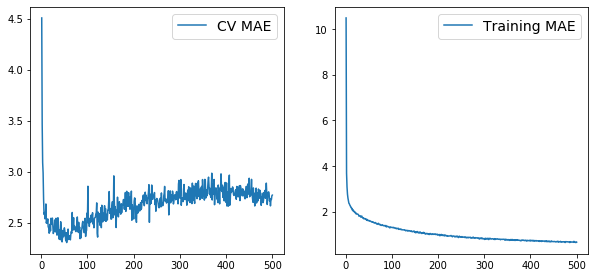

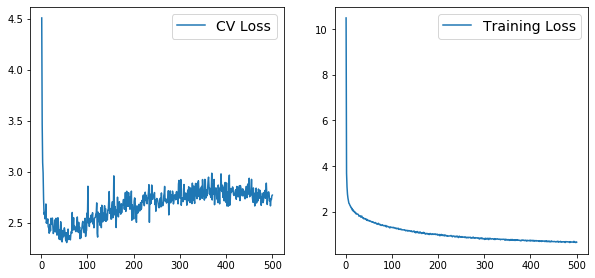

In [32]:
import pylab as plt

avg_mae_cv=[ np.mean([ x[i] for x in all_mae_cv]) for i in range(num_epochs)]
avg_loss_cv=[ np.mean([ x[i] for x in all_loss_cv]) for i in range(num_epochs)]
avg_mae_train=[ np.mean([ x[i] for x in all_mae_train]) for i in range(num_epochs)]
avg_loss_train=[ np.mean([ x[i] for x in all_loss_train]) for i in range(num_epochs)]

xx=range(1, len(avg_mae_cv)+1)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(xx, avg_mae_cv, label='CV MAE')
plt.legend(loc='best', fontsize=14)

plt.subplot(222)
plt.plot(xx, avg_mae_train, label='Training MAE')
plt.legend(loc='best', fontsize=14)
plt.figure(figsize=(10,10))

plt.subplot(223)
plt.plot(xx, avg_loss_cv, label='CV Loss')
plt.legend(loc='best', fontsize=14)

plt.subplot(224)
plt.plot(xx, avg_loss_train, label='Training Loss')
plt.legend(loc='best', fontsize=14)

plt.show()

Let's smoothen the plots as it's hard to see the variation in the CV plots. Let's do the following

1. Skip first few points (say 10) as they are on a different scale
2. smoothen the curve by adding some factor of previous point (exponential moving average)

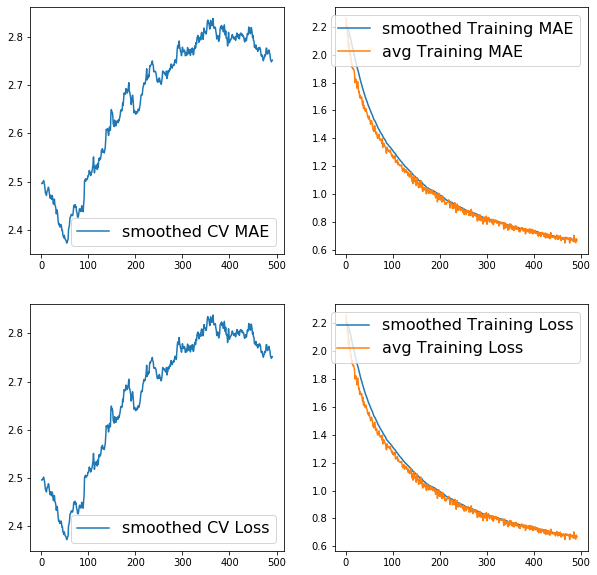

In [54]:
def smooth_curve(dat, factor=0.9):
    smoothed_pts=[dat[0]]
    for pt in dat:
        previous=smoothed_pts[-1]
        smoothed_pts.append( previous*factor+ pt*(1.-factor) )
    return smoothed_pts

plt.figure(figsize=(10,10))

plt.subplot(221)
sm_mae_cv=smooth_curve(avg_mae_cv[10:])
xx=range(1, len(sm_mae_cv)+1)
plt.plot(xx, sm_mae_cv, label='smoothed CV MAE')
plt.legend(loc='best', fontsize=16)

sm_mae_train=smooth_curve(avg_mae_train[10:])
plt.subplot(222)
plt.plot(xx, sm_mae_train, label='smoothed Training MAE')
plt.plot(xx, avg_mae_train[9:], label='avg Training MAE')

plt.legend(loc='best', fontsize=16)

sm_loss_cv=smooth_curve(avg_loss_cv[10:])
plt.subplot(223)
plt.plot(xx, sm_loss_cv, label='smoothed CV Loss')
plt.legend(loc='best', fontsize=16)

sm_loss_train=smooth_curve(avg_loss_train[10:])
plt.subplot(224)
plt.plot(xx, sm_loss_train, label='smoothed Training Loss')
plt.plot(xx, avg_loss_train[9:], label='avg Training Loss')
plt.legend(loc='best', fontsize=16)

plt.show()



Looking at the CV MAE we can see that after about 80 epochs the model starts ovefitting.

In [49]:
mymodel=Build_model()
mymodel.fit(x_train, y_train, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score=mymodel.evaluate(x_test, y_test)

102/102 [==============================] - 0s 188us/step


In [50]:
print (test_mae_score)

2.7190725803375244
